In [ ]:
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import glob
import random
from torch.utils.data import Dataset
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output
from icecream import ic

In [ ]:
!unzip test.zip

Archive:  test.zip
   creating: test/
  inflating: test/1.jpg              
  inflating: test/10.jpg             
  inflating: test/100.jpg            
  inflating: test/101.jpg            
  inflating: test/102.jpg            
  inflating: test/103.jpg            
  inflating: test/104.jpg            
  inflating: test/105.jpg            
  inflating: test/106.jpg            
  inflating: test/11.jpg             
  inflating: test/12.jpg             
  inflating: test/13.jpg             
  inflating: test/14.jpg             
  inflating: test/15.jpg             
  inflating: test/16.jpg             
  inflating: test/17.jpg             
  inflating: test/18.jpg             
  inflating: test/19.jpg             
  inflating: test/2.jpg              
  inflating: test/20.jpg             
  inflating: test/21.jpg             
  inflating: test/22.jpg             
  inflating: test/23.jpg             
  inflating: test/24.jpg             
  inflating: test/25.jpg             
  inflating:

In [ ]:
class Hyperparameters(object):

      def __init__(self, **kwargs):
            self.__dict__.update(kwargs)

hp = Hyperparameters(
    epoch=0,
    n_epochs=200,
    batch_size=8,
    dataset_train_mode="train",
    dataset_test_mode="val",
    lr=.0002,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    latent_dim=8,
    n_critic=5,
    sample_interval=400,
    lambda_pixel=10,
    lambda_latent=.5,
    lambda_kl=.01)
img_root_folder = '/content'

In [ ]:
class ImageDataset(Dataset):

    def __init__(self,root,transforms_=None,mode='train'):
        self.transforms = transforms.Compose(transforms_)

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.*")))

    def __getitem__(self,index):
        img = Image.open(self.files[index%len(self.files)])
        w,h=img.size
        img_A = img.crop((0,0,w/2,h))
        img_B = img.crop((w/2,0,w,h))

        if np.random.random() < 0.5:

            img_A = Image.fromarray(np.array(img_A)[:,::-1,:],"RGB")
            img_B = Image.fromarray(np.array(img_B)[:,::-1,:],"RGB")

        img_A = self.transforms(img_A)
        img_B = self.transforms(img_B)

        return {"A" : img_A, "B" : img_B}

    def __len__(self):
          return len(self.files)


In [ ]:
def imshow(img,size=10):
    img = img/2+0.5
    npimg = img.numpu()
    plt.figure(figsize=size)
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

def visualize_output(path,w,h):
      img = mpimg.imread(path)
      plt.figure(figsize=(w,h))
      plt.imshow(img)
      plt.show()

In [ ]:
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

train_dataloader = DataLoader(
    ImageDataset(img_root_folder, mode=hp.dataset_train_mode, transforms_=transforms_),  # Fix here
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)

val_dataloader = DataLoader(
    ImageDataset(img_root_folder, mode=hp.dataset_test_mode, transforms_=transforms_),  # Fix here
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

In [ ]:
from torchvision.models import resnet18

In [ ]:
def weight_class_init(m):

    classname = m.__class__.__name__
    if classname.find("Conv")!=-1:
        torch.nn.init.normal_(m.weight.data,0.0,0.2)
    if classname.find("BatchNorm2d")!=-1:
        torch.nn.init.normal_(m.weight.data,1.0,0.2)
        torch.nn.init.constant_(m.weight.data,0.0)

In [ ]:
class UNetDown(nn.Module):
     def __init__(self,in_size,out_size,normalize=True,dropout=0.0):
            super(UNetDown,self).__init__()
            layers = [nn.Conv2d(in_size,out_size,3,stride=2,padding=1,bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_size,0.8))
            layers.append(nn.LeakyReLU(0.2))
            self.model= nn.Sequential(*layers)

     def forward(self,x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self,in_size,out_size):
        super(UNetUp,self).__init__()
        self.model=nn.Sequential(
                   nn.Upsample(scale_factor=2),
                   nn.Conv2d(in_size,out_size,3,stride=1,padding=1,bias=False),
                   nn.BatchNorm2d(out_size,0.8),
                   nn.ReLU(inplace=True),
        )

    def forward(self,x,skip_input):
        x=self.model(x)
        x=torch.cat((x,skip_input),1)
        return x



In [ ]:
class Generator(nn.Module):
    def __init__(self,latent_dim,img_shape):
        super(Generator,self).__init__()
        channels,self.h,self.w=img_shape

        self.fc = nn.Linear(latent_dim,self.h*self.w)

        self.down1=UNetDown(channels+1,64,normalize=True)
        self.down2=UNetDown(64,128)
        self.down3=UNetDown(128,256)
        self.down4=UNetDown(256,512)
        self.down5=UNetDown(512,512)
        self.down6=UNetDown(512,512)
        self.down7=UNetDown(512,512,normalize=False)
        self.up1=UNetUp(512,512)
        self.up2=UNetUp(1024,512)
        self.up3=UNetUp(1024,512)
        self.up4=UNetUp(1024,256)
        self.up5=UNetUp(512,128)
        self.up6=UNetUp(256,64)

        self.final = nn.Sequential(
                     nn.Upsample(scale_factor=2),
                     nn.Conv2d(128,channels,3,stride=1,padding=1),nn.Tanh())

    def forward(self,x,z):
        z = self.fc(z).view(z.size(0),1,self.h,self.w)
        d1=self.down1(torch.cat((x,z),1))
        d2=self.down2(d1)
        d3=self.down3(d2)
        d4=self.down4(d3)
        d5=self.down5(d4)
        d6=self.down6(d5)
        d7=self.down7(d6)
        u1=self.up1(d7,d6)
        u2=self.up2(u1,d5)
        u3=self.up3(u2,d4)
        u4=self.up4(u3,d3)
        u5=self.up5(u4,d2)
        u6=self.up6(u5,d1)

        return self.final(u6)


In [ ]:
class Encoder(nn.Module):
    def __init__(self,latent_dim,input_shape):
        super(Encoder,self).__init__()
        resnet18_model = resnet18(pretrained=False)
        self.feature_extractor = nn.Sequential(*list(resnet18_model.children())[:-3])
        self.pooling = nn.AvgPool2d(kernel_size = 8, stride=8, padding=0)
        self.fc_mu = nn.Linear(256,latent_dim)
        self.fc_logvar = nn.Linear(256,latent_dim)

    def forward(self,img):
        out = self.feature_extractor(img)
        out = self.pooling(out)
        out = out.view(out.size(0),-1)
        mu = self.fc_mu(out)
        var = self.fc_logvar(out)
        return mu,var

In [ ]:
class MultiDiscriminator(nn.Module):
        def __init__(self,input_shape):
            super(MultiDiscriminator,self).__init__()
            def discriminator_block(in_filters,out_filters,normalize=True):
                    layers = [nn.Conv2d(in_filters,out_filters,4,stride=2,padding=1)]
                    if normalize:
                        layers.append(nn.BatchNorm2d(out_filters,0.8))
                    layers.append(nn.LeakyReLU(0.8))
                    return layers

            channels,_,_=input_shape
            self.models = nn.ModuleList()
            for i in range(3):
                self.models.add_module(
                    "disc_%d"%i,
                    nn.Sequential(
                    *discriminator_block(channels,64,normalize=False),
                    *discriminator_block(64,128),
                    *discriminator_block(128,264),
                    *discriminator_block(264,512),
                    nn.Conv2d(512,1,3,padding=2)
                    ),
                )
            self.downsample = nn.AvgPool2d(channels,stride=1,padding=[1,1],count_include_pad=False)

        def compute_loss(self,x,ground_truth):
            loss = sum([torch.mean((out-ground_truth)**2) for out in self.forward(x)])
            return loss

        def forward(self,x):
            outputs=[]
            for m in self.models:
              outputs.append(m(x))
              x=self.downsample(x)
              return outputs

In [ ]:
cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

mae_loss= torch.nn.L1Loss()
input_shape=(hp.channels,hp.img_size,hp.img_size)

generator=Generator(hp.latent_dim,input_shape)
encoder = Encoder(hp.latent_dim,input_shape)

D_VAE = MultiDiscriminator(input_shape)
D_LR = MultiDiscriminator(input_shape)

if cuda:
    generator = generator.cuda()
    encoder.cuda()
    D_VAE.cuda()
    D_LR.cuda()
    mae_loss.cuda()

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # Initialize convolutional layer weights
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)  # Initialize batch normalization weights
        nn.init.constant_(m.bias.data, 0.0)

generator.apply(weights_init_normal)
D_VAE.apply(weights_init_normal)
D_LR.apply(weights_init_normal)


Using CUDA


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MultiDiscriminator(
  (models): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.8)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.8)
      (5): Conv2d(128, 264, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(264, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.8)
      (8): Conv2d(264, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.8)
      (11): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    )
  )
  (downsample): AvgPool2d(kernel_size=3, stride=1, padding=[1, 1])
)

In [ ]:
def sample_images(batches_done):
    generator.eval()
    img = next(iter(val_dataloader))
    image_samples = None
    path = "/content/%s/%s.png" % ('maps', batches_done)
    for img_A , img_B in zip(img["A"],img["B"]):
        real_A = img_A.view(1,*img_A.shape).repeat(hp.latent_dim,1,1,1)
        real_A = Variable(real_A.type(Tensor))
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (hp.latent_dim, hp.latent_dim))))
        fake_B = generator(real_A, sampled_z)
        fake_B = torch.cat([x for x in fake_B.data.cpu()], -1)
        img_sample = torch.cat((img_A, fake_B), -1)
        img_sample = img_sample.view(1, *img_sample.shape)
        img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)
    save_image(img_samples, path, nrow=8, normalize=True)
    generator.train()
    return path

In [ ]:
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D_VAE = torch.optim.Adam(D_VAE.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D_LR = torch.optim.Adam(D_LR.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [ ]:
def reparameterization(z_mean, z_log_var):
    std = torch.exp(z_log_var / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (z_mean.size(0), hp.latent_dim))))
    z = z_mean + sampled_z * std
    return z

In [ ]:

#  TRAINING
# Adversarial loss
valid = 1
fake = 0

prev_time = time.time()
for epoch in range(hp.epoch, hp.n_epochs):
    for i, batch in enumerate(train_dataloader):

        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))

        ################################
        #  Train Generator and Encoder
        #################################
        '''  The first component of Bicycle-GAN is cVAE-GAN. It first encodes the ground truth image(B) into the latent space using encoder E.

        ### Then input image(A) and encoded ground truth image(i.e. latent vector - Z) are passed into the Generator G which produces the output image(B^). That is, The generator attempts to map the input image A along with a sampled z back into the original image B.
        the flow of cVAE-GAN => B -> Z -> B^
        '''

        optimizer_E.zero_grad()
        optimizer_G.zero_grad()

        #################
        # cVAE-GAN
        #################

        mu, logvar = encoder(real_B)
        # reparameterize so backprogation can be done on the
        # stochastically generated z variable
        encoded_z = reparameterization(mu, logvar)
        fake_B = generator(real_A, encoded_z)

        # Pixelwise loss of translated image by VAE
        loss_pixel_L1_vae = mae_loss(fake_B, real_B)

        # Kullback-Leibler divergence of encoded B
        # Refer - https://stackoverflow.com/questions/61597340/how-is-kl-divergence-in-pytorch-code-related-to-the-formula
        loss_kl = 0.5 * torch.sum(torch.exp(logvar) + mu ** 2 - logvar - 1)
        # Adversarial loss
        # compute_loss() - Computes the MSE between model output and scalar ground_truth
        loss_VAE_GAN = D_VAE.compute_loss(fake_B, valid)

        ####################################
        # cLR-GAN
        # Conditional Latent Regressor GAN
        ####################################

        ''' This is the second component of the Bicycle-GAN. Here a randomly drawn latent vector (sampled_z below) along with the input image(A) is provided to the generator. The generated output(B^) may not look like ground truth image(B), but it should look realistic.
        Then the generated output is passed through the encoder, encoder tries to regain the latent vector from the output image.

        the flow of cLR-GAN is Z -> B^ -> Z^
        '''

        # real_A need to be a 4-D Tensor of Batch_size, Channel, Height, Width
        # ic(real_A.size()) # torch.Size([8, 3, 128, 128])
        # Produce output using sampled z (cLR-GAN)
        # sampled_z need to be a 2-D Tensor of Batch_size (i.e. 8) and Latent_dim (i.e 8)
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (real_A.size(0), hp.latent_dim))))
        # Draw random samples from a normal (Gaussian) distribution.
        # ic(sampled_z.size()) # torch.Size([8, 8])
        ''' ic(sampled_z) will output below
        tensor([[ 0.2202,  0.3848, -1.0489, -0.5884, -0.0094,  0.1678, -1.5106, -0.2802],
                       [ 1.9893, -0.8738, -2.4284,  1.0219,  0.4162,  0.3345, -1.7501,  0.0511],
                       [-0.5878,  0.0200, -0.9107,  0.8697, -1.8777,  0.3819,  0.4788, -3.0111],
                       [ 0.9784,  0.7068, -0.2902,  0.9084,  0.2643, -0.0090,  0.6117, -1.4820],
                       [-0.1651, -0.5930,  0.1434,  1.6912, -0.6974, -1.7704, -3.2449, -0.4491],
                       [-1.1474, -1.6918,  1.6326, -0.7691,  0.4847,  2.0244, -0.3476, -1.1350],
                       [ 0.3965,  0.3789,  0.3177, -1.5840,  0.6150, -1.4996,  0.2707, -0.7499],
                       [-0.1608, -0.8812, -0.0048, -0.6618, -0.5037, -0.8252,  0.7017,  0.4248]],
                      device='cuda:0') '''

        _fake_B = generator(real_A, sampled_z)
        # cLR Loss: Adversarial loss
        loss_CLR_GAN = D_LR.compute_loss(_fake_B, valid)

        #########################################
        # Total Loss (Generator + Encoder)
        #########################################

        loss_total_gen_encoder = loss_VAE_GAN + loss_CLR_GAN + hp.lambda_pixel * loss_pixel_L1_vae + hp.lambda_kl * loss_kl

        loss_total_gen_encoder.backward(retain_graph=True)
        optimizer_E.step()

        ######################
        # Generator Only Loss
        ######################
        '''Under CLR-GAN - Then the generated output (_fake_B) is passed through the encoder, encoder tries to regain the latent vector from the output image. '''

        # Latent L1 loss
        _mu, _ = encoder(_fake_B)
        loss_latent = hp.lambda_latent * mae_loss(_mu, sampled_z)

        loss_latent.backward()
        optimizer_G.step()

        #######################################
        #  Train Discriminator (cVAE-GAN)
        #######################################

        optimizer_D_VAE.zero_grad()

        loss_D_VAE = D_VAE.compute_loss(real_B, valid) + D_VAE.compute_loss(fake_B.detach(), fake)

        loss_D_VAE.backward()
        optimizer_D_VAE.step()

        ####################################
        # Train Discriminator (cLR-GAN)
        # Conditional Latent Regressor GAN
        ####################################

        optimizer_D_LR.zero_grad()

        loss_D_LR = D_LR.compute_loss(real_B, valid) + D_LR.compute_loss(_fake_B.detach(), fake)

        loss_D_LR.backward()
        optimizer_D_LR.step()

        #################
        #  Log Progress
        #################

        # Determine approximate time left
        batches_done = epoch * len(train_dataloader) + i
        batches_left = hp.n_epochs * len(train_dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D VAE_loss: %f, LR_loss: %f] [G loss: %f, pixel: %f, kl: %f, latent: %f] ETA: %s"
            % (
                epoch,
                hp.n_epochs,
                i,
                len(train_dataloader),
                loss_D_VAE.item(),
                loss_D_LR.item(),
                loss_total_gen_encoder.item(),
                loss_pixel_L1_vae.item(),
                loss_kl.item(),
                loss_latent.item(),
                time_left,
            )
        )

        # If at sample interval save image
        if batches_done % hp.sample_interval == 0:
          clear_output()

[Epoch 199/200] [Batch 63/64] [D VAE_loss: 0.502077, LR_loss: 0.500558] [G loss: 1.740281, pixel: 0.123720, kl: 0.000810, latent: 0.344174] ETA: 0:00:00.141132

In [ ]:
import torch

# Define a path to save the models
save_path = "bicycleGAN_checkpoint.pth"

# Save all models and optimizers
torch.save({
    'generator': generator.state_dict(),
    'encoder': encoder.state_dict(),
    'D_VAE': D_VAE.state_dict(),
    'D_LR': D_LR.state_dict(),
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_E': optimizer_E.state_dict(),
    'optimizer_D_VAE': optimizer_D_VAE.state_dict(),
    'optimizer_D_LR': optimizer_D_LR.state_dict(),
    'epoch': epoch
}, save_path)

print(f"Model saved successfully at {save_path}")


Model saved successfully at bicycleGAN_checkpoint.pth


In [ ]:
# Load the checkpoint
checkpoint = torch.load(save_path)

# Restore models
generator.load_state_dict(checkpoint['generator'])
encoder.load_state_dict(checkpoint['encoder'])
D_VAE.load_state_dict(checkpoint['D_VAE'])
D_LR.load_state_dict(checkpoint['D_LR'])

# Restore optimizers
optimizer_G.load_state_dict(checkpoint['optimizer_G'])
optimizer_E.load_state_dict(checkpoint['optimizer_E'])
optimizer_D_VAE.load_state_dict(checkpoint['optimizer_D_VAE'])
optimizer_D_LR.load_state_dict(checkpoint['optimizer_D_LR'])

# Restore epoch number
start_epoch = checkpoint['epoch']

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
test_dataloader = DataLoader(
    ImageDataset(img_root_folder, mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=hp.batch_size,  # Keep batch size consistent
    shuffle=False,  # No need to shuffle for testing
    num_workers=1,  # Reduce workload
)


Real Input (Domain A):


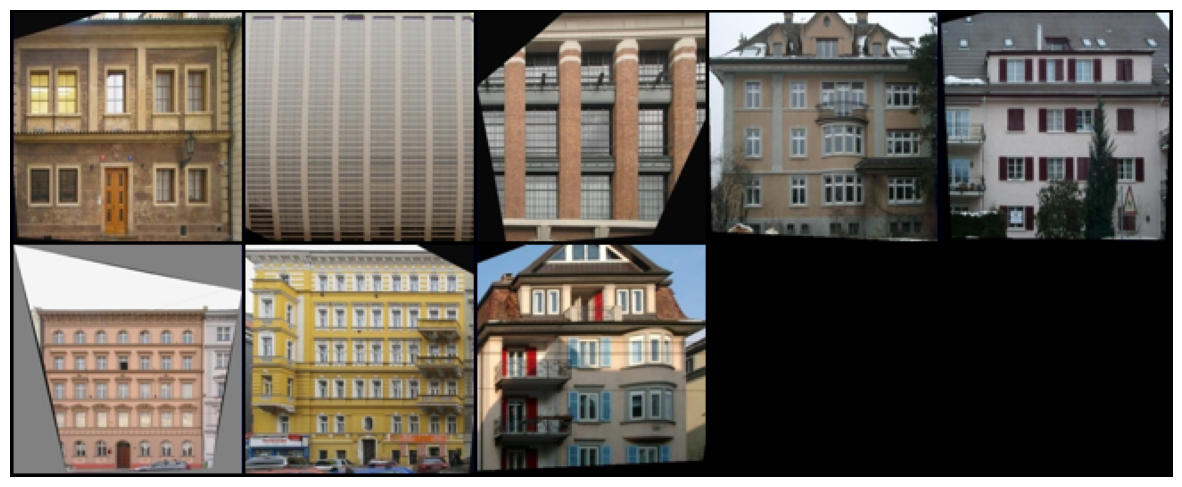

Real Target (Domain B):


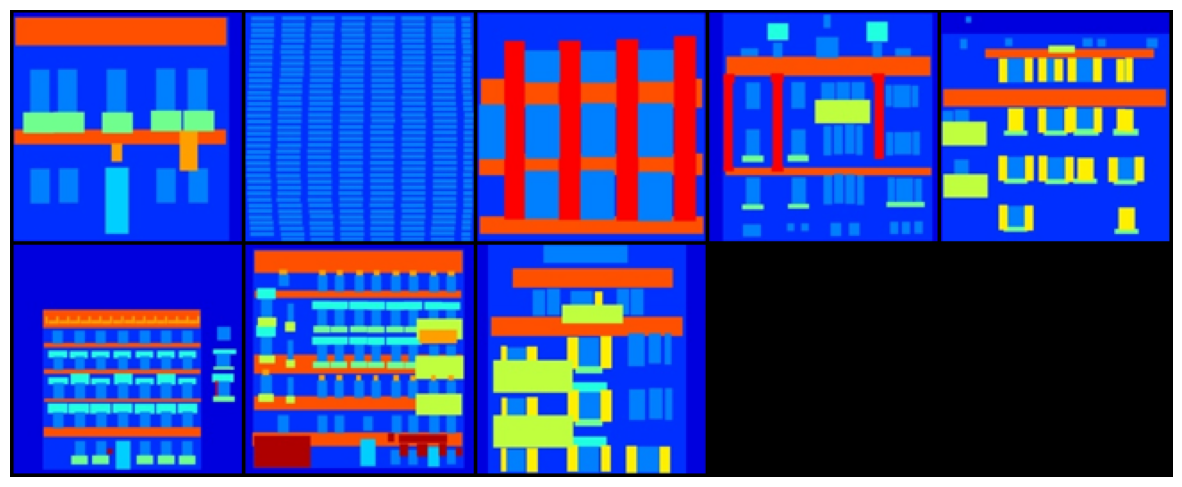

Encoder-based Generation (Deterministic):


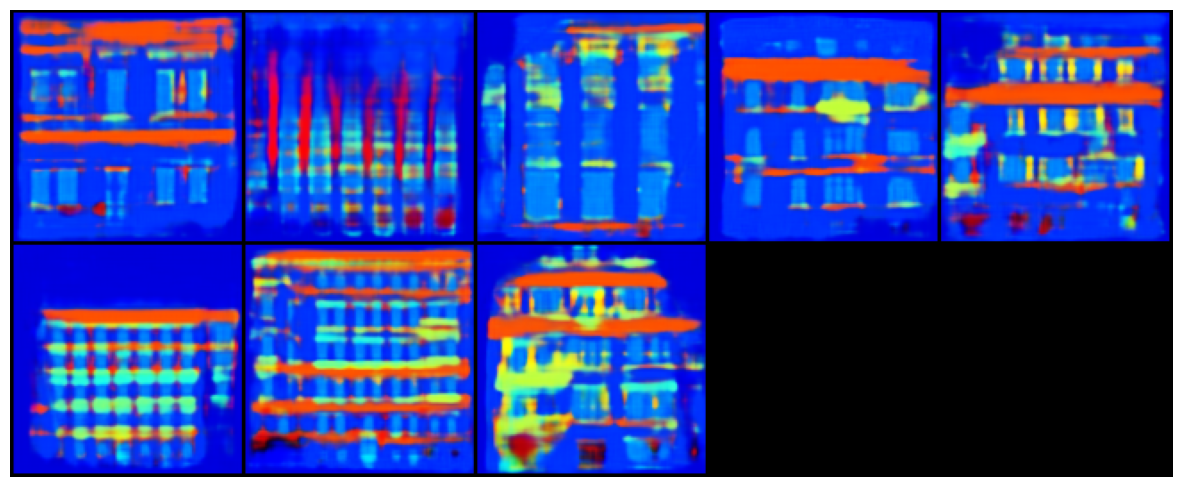

Random Generation:


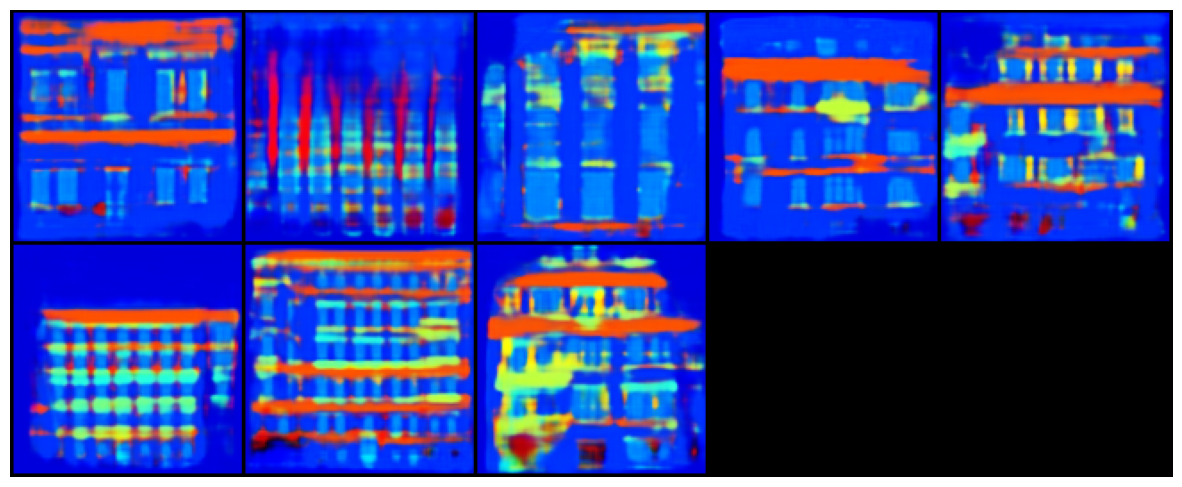

Interpolation in Latent Space:


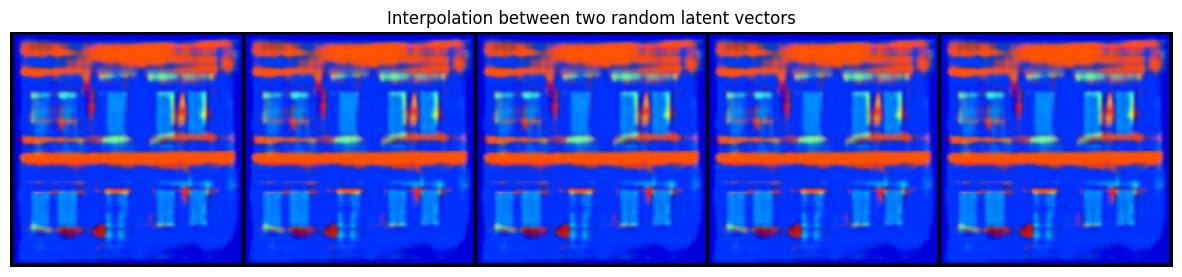

Multiple Random Samples:


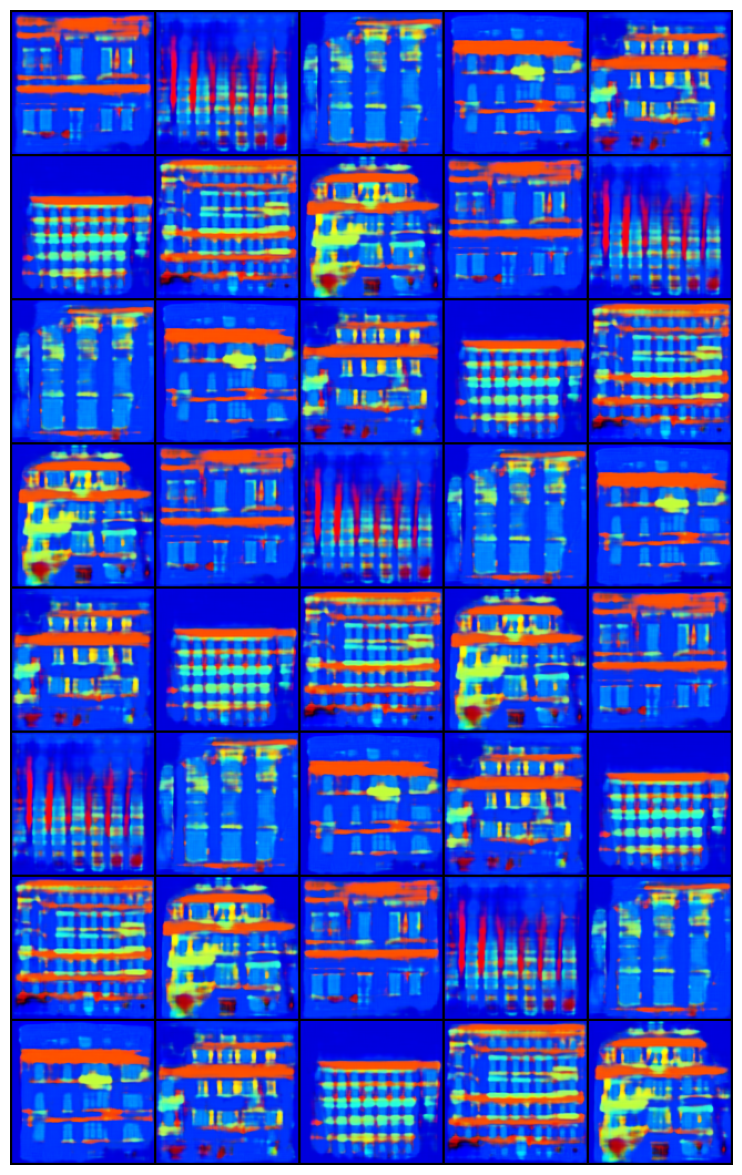

In [ ]:

# Set models to evaluation mode
generator.eval()
encoder.eval()  # BicycleGAN has an encoder for the latent space

# Load a sample test image
test_batch = next(iter(test_dataloader))
real_A = test_batch["A"].type(Tensor)  # Input image (domain A)
real_B = test_batch["B"].type(Tensor)  # Target image (domain B)

# Convert to Variables if needed (depends on your PyTorch version)
if torch.__version__ < '0.4.0':
    real_A = Variable(real_A)
    real_B = Variable(real_B)

# Generate images in different ways as per BicycleGAN
with torch.no_grad():  # No need to track gradients during inference
    # 1. Encoder-based generation (deterministic output)
    mu, logvar = encoder(real_B)
    encoded_z = reparameterization(mu, logvar)  # Sample from the encoded distribution
    encoded_B = generator(real_A, encoded_z)

    # 2. Random sampling (random output)
    random_z = Variable(Tensor(np.random.normal(0, 1, (real_A.size(0), hp.latent_dim))))
    random_B = generator(real_A, random_z)

    # 3. Interpolation between two random z vectors
    z1 = Variable(Tensor(np.random.normal(0, 1, (1, 8))))
    z2 = Variable(Tensor(np.random.normal(0, 1, (1, 8))))
    alpha = torch.linspace(0, 1, 5).view(-1, 1, 1, 1).type(Tensor)
    interpolated_z = alpha * z1 + (1 - alpha) * z2
    # Repeat the same input image for interpolation
    repeated_A = real_A[0:1].repeat(5, 1, 1, 1)
    interpolated_B = generator(repeated_A, interpolated_z)

# Convert tensors to images and display
def show_images(images, title=None):
    images = images.cpu()  # Move to CPU
    grid = vutils.make_grid(images, nrow=5, normalize=True, padding=2)  # Create a grid
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0))  # Change from CxHxW to HxWxC
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Show results
print("Real Input (Domain A):")
show_images(real_A)

print("Real Target (Domain B):")
show_images(real_B)

print("Encoder-based Generation (Deterministic):")
show_images(encoded_B)

print("Random Generation:")
show_images(random_B)

print("Interpolation in Latent Space:")
show_images(interpolated_B, "Interpolation between two random latent vectors")

# For models with multiple outputs (multi-modal), you might want to show several samples
if 5 > 1:
    print("Multiple Random Samples:")
    all_samples = []
    for _ in range(5):  # Generate 5 random samples
        z = Variable(Tensor(np.random.normal(0, 1, (real_A.size(0), hp.latent_dim))))
        all_samples.append(generator(real_A, z))
    show_images(torch.cat(all_samples, dim=0))